In [1]:
from typing import Annotated
import operator,json
from typing import TypedDict, Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph,END,START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

In [2]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [3]:
llm.invoke("hi")

AIMessage(content='Hello! 👋\n\nHow can I help you today? 😊\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 10, 'total_tokens': 25, 'completion_time': 0.027272727, 'prompt_time': 6.2e-07, 'queue_time': 0.024373859, 'total_time': 0.027273347}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-ce147400-ea90-43dd-8d0c-c659e5a93702-0', usage_metadata={'input_tokens': 10, 'output_tokens': 15, 'total_tokens': 25})

In [4]:
llm.invoke("hi").content

'Hello! 👋  How can I help you today?\n'

In [5]:
@tool
def multiply(first_number:int, second_number:int)->int:
    """multiply two integer number"""
    return first_number * second_number

In [6]:
multiply({"first_number":20,"second_number":27})

C:\Users\Toshiba\AppData\Local\Temp\ipykernel_3780\623416424.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  multiply({"first_number":20,"second_number":27})


540

In [7]:
multiply.invoke({"first_number":20,"second_number":27})

540

In [8]:
@tool
def search(query:str):
    """perform the web search on the user query"""
    tavily=TavilySearchResults()
    result=tavily.invoke(query)
    return result

In [9]:
search("who is the new president of USA?")

[{'url': 'https://www.bbc.co.uk/newsround/articles/ce3nq0rexqeo',
  'content': 'Donald Trump officially becomes new US president - BBC Newsround Donald Trump officially becomes new US president In a special ceremony called an inauguration, President Trump took over from Joe Biden as America\'s new leader. In his first speech as president after swearing the oath, Mr Trump promised to make America "greater, stronger, and far more exceptional than ever before". It\'s the second time that Mr Trump has taken on the role - having previously served as president before Joe Biden, between 2017-2021. Donald Trump: What happens at the inauguration of the new US president? What are Donald Trump\'s plans as president? Following his oath, Mr Trump gave his first speech as president - which is known as the Inaugural Address.'},
 {'url': 'https://www.usa.gov/presidents',
  'content': 'Vice president of the United States\nThe vice president of the United States presides over the U.S. Senate and takes o

In [10]:
search.invoke("who is the new president of USA?")

[{'url': 'https://www.usnews.com/news/politics/articles/2025-01-20/inauguration-day-latest-biden-pardons-fauci-milley-and-jan-6-committee-before-trump-takes-office',
  'content': 'President Joe Biden and President-elect Donald Trump walk out to the presidential limousine, as they depart the White House, Monday, Jan. 20, 2025, in Washington, enroute to the Capitol. WASHINGTON (AP) — Donald Trump, who overcame impeachments, criminal indictments and a pair of assassination attempts to win another term in the White House, will be sworn in Monday as the 47th U.S. president taking charge as Republicans claim unified control of Washington and set out to reshape the country’s institutions. “Feel great,” said House Majority Leader Steve Scalise, R-La. President-elect Donald Trump and Vice President-elect JD Vance arrive at the Capitol ahead of their inauguration “Welcome home,” Biden said to Trump after the president-elect stepped out of the car.'},
 {'url': 'https://www.usa.gov/presidents',
  

In [11]:
tools=[search,multiply]

In [12]:
model_with_tools = llm.bind_tools(tools)

In [13]:
tool_mapping={tool.name: tool for tool in tools}

In [14]:
tool_mapping

{'search': StructuredTool(name='search', description='perform the web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000002290A1C4AF0>),
 'multiply': StructuredTool(name='multiply', description='multiply two integer number', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x0000022906722DD0>)}

In [23]:
response = model_with_tools.invoke("who is the new president of USA?")

In [25]:
response #here it is not returning the result because it is in the process of calling the search tool only

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_km3n', 'function': {'arguments': '{"query":"who is the new president of USA"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 85, 'prompt_tokens': 1076, 'total_tokens': 1161, 'completion_time': 0.154545455, 'prompt_time': 0.034723759, 'queue_time': 0.023374611000000003, 'total_time': 0.189269214}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-02c7649f-435f-471e-a5b1-2761d078c2d2-0', tool_calls=[{'name': 'search', 'args': {'query': 'who is the new president of USA'}, 'id': 'call_km3n', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1076, 'output_tokens': 85, 'total_tokens': 1161})

In [26]:
tool_details=response.additional_kwargs.get("tool_calls")

In [27]:
tool_details

[{'id': 'call_km3n',
  'function': {'arguments': '{"query":"who is the new president of USA"}',
   'name': 'search'},
  'type': 'function'}]

In [28]:
tool_details[0]["function"]["name"]

'search'

In [29]:
tool_details[0]["function"]["arguments"]

'{"query":"who is the new president of USA"}'

In [31]:
json.loads(tool_details[0]["function"]["arguments"])

{'query': 'who is the new president of USA'}

In [30]:
tool_mapping[tool_details[0]["function"]["name"]].invoke(json.loads(tool_details[0]["function"]["arguments"]))

[{'url': 'https://www.bbc.co.uk/newsround/articles/ce3nq0rexqeo',
  'content': 'Donald Trump officially becomes new US president - BBC Newsround Donald Trump officially becomes new US president In a special ceremony called an inauguration, President Trump took over from Joe Biden as America\'s new leader. In his first speech as president after swearing the oath, Mr Trump promised to make America "greater, stronger, and far more exceptional than ever before". It\'s the second time that Mr Trump has taken on the role - having previously served as president before Joe Biden, between 2017-2021. Donald Trump: What happens at the inauguration of the new US president? What are Donald Trump\'s plans as president? Following his oath, Mr Trump gave his first speech as president - which is known as the Inaugural Address.'},
 {'url': 'https://www.rollingstone.com/politics/politics-news/donald-trump-sworn-in-47th-president-united-states-1235241770/',
  'content': 'Outgoing President Joe Biden greet

In [15]:
class AgentState(TypedDict): #Capture the message [list] of the entire execution.
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [16]:
def invoke_model(state:AgentState):
    messages = state['messages']
    question = messages[-1]   ## Fetching the user question
    return {"messages":[model_with_tools.invoke(question)]}

In [17]:
def invoke_tool(state:AgentState):
    tool_details= state['messages'][-1].additional_kwargs.get("tool_calls", [])[0]
    
    if tool_details is None:
        raise Exception("no tool call found")
    
    print(f'Selected tool: {tool_details.get("function").get("name")}')
    
    if tool_details.get("function").get("name")=="search": #Human intervention
        response = input(prompt=f"[y/n] continue with expensive web search?")
        if response == "n":
            raise Exception("web search discard")
    #Final call with custom logic
    response = tool_mapping[tool_details['function']['name']].invoke(json.loads(tool_details.get("function").get("arguments")))
    return {"messages" : [response]}

In [18]:
def router(state):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "tool"
    else:
        return "end"

In [19]:
graph = StateGraph(AgentState) ### StateGraph with AgentState

graph.add_node("ai_assistant", invoke_model)

graph.add_node("tool", invoke_tool)

In [20]:
graph.add_conditional_edges("ai_assistant", router, {"tool": "tool","end": END,})

graph.add_edge("tool", END)

#graph.add_edge("tool", "ai_assistant")

graph.set_entry_point("ai_assistant")

In [21]:
app = graph.compile()

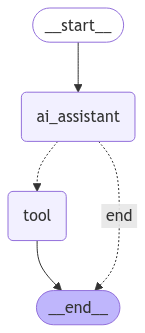

In [22]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [32]:
for s in app.stream({"messages": ["who is the new president of USA?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jnq5', 'function': {'arguments': '{"query":"who is the new president of USA"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 1076, 'total_tokens': 1162, 'completion_time': 0.156363636, 'prompt_time': 0.034526679, 'queue_time': 0.024503990000000003, 'total_time': 0.190890315}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-50411af7-370e-47c6-bf48-ae5d8c6cfb57-0', tool_calls=[{'name': 'search', 'args': {'query': 'who is the new president of USA'}, 'id': 'call_jnq5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1076, 'output_tokens': 86, 'total_tokens': 1162})]}
----
Selected tool: search
{'messages': [[{'url': 'https://www.bbc.co.uk/newsround/articles/ce3nq0rexqeo', 'content': 'Donald Trump officially becomes new US president - BBC Newsround Don

In [33]:
for s in app.stream({"messages": ["multiplication of 20 and 6?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gmf5', 'function': {'arguments': '{"first_number":20,"second_number":6}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 1077, 'total_tokens': 1167, 'completion_time': 0.163636364, 'prompt_time': 0.034475916, 'queue_time': 0.023676624, 'total_time': 0.19811228}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-89d2c5a1-9e72-45df-bee6-8983153efb8c-0', tool_calls=[{'name': 'multiply', 'args': {'first_number': 20, 'second_number': 6}, 'id': 'call_gmf5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1077, 'output_tokens': 90, 'total_tokens': 1167})]}
----
Selected tool: multiply
{'messages': [120]}
----


In [34]:
for s in app.stream({"messages": ["How many countries are exists over the earth?"]}):
    print(list(s.values())[0])
    print("----")

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xqsg', 'function': {'arguments': '{"query":"how many countries are in the world"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 1077, 'total_tokens': 1163, 'completion_time': 0.156363636, 'prompt_time': 0.0354565, 'queue_time': 0.022902936999999998, 'total_time': 0.191820136}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6042934f-e227-440b-8af3-15d16a1ad1d7-0', tool_calls=[{'name': 'search', 'args': {'query': 'how many countries are in the world'}, 'id': 'call_xqsg', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1077, 'output_tokens': 86, 'total_tokens': 1163})]}
----
Selected tool: search
{'messages': [[{'url': 'https://www.geeksforgeeks.org/how-many-countries-are-there-in-the-world/', 'content': "List of countries in the world: Have you ev